## Example: codewords in the premotor neuronal activity in songbirds in relation to pitch 

In this notebook, we analyze the premotor activity (RA, two synapses away from vocal muscles) of single neurons in Bengalese finches in relation to the pitch of individual vocal gestures (syllables). The activity in discretized in 2ms bins, and binarized (spike=1, no-spike=0). 

- First we binarized the behavior as $x_0=1$ if pitch is above the median, and look for codewords that include the behavior and overoccur, using uBIA.
- Strong interactions may induce that its superwords (words that include such interaction) are detected incorrectly as codewords. As an exercise, we will binarized the behavior as $x_0=1$ if pitch is below the median and run uBIA again. Next, we will check whether there are coincidences between the list of codewords that overoccur with low pitch and the list of codewords that overoccur with high pitch. If there are, these coincidences should be discarted, as they are only detected due to strong spike-spike interactions.

Make sure uBIAmodule.py is located in your working folder before importing.

In [2]:
from itertools import product, combinations
import numpy as np
import math
import operator
from matplotlib import pyplot as plt
import functools
def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)
def list_powerset(lst):
    return functools.reduce(lambda result, x: result + [subset + [x] for subset in result], lst, [[]])
from collections import Counter
import time
from sklearn.utils import shuffle
from heapq import nsmallest
import scipy.io
import statistics
from matplotlib import colors

#--------------------
import uBIAmodule

### Loading data
Make sure that these files are located in your working folder.

In [3]:
data1 = scipy.io.loadmat('songbird_data1_pitch.mat')
data2 = scipy.io.loadmat('songbird_data1_premotor.mat')

pitch_data=data1['Expression1']
print(len(pitch_data))
median_p=statistics.median(pitch_data)
pitch_binary=np.where(pitch_data>median_p,1,0)
#print(pitch_binary)

spikes_data=data2['Expression1']
print(len(spikes_data))
print(len(spikes_data[0]))
M=len(pitch_data)

# "samples" has in its first component (index=0) the binarized behavior (pitch>median), 
# and then spike/no spike in 2ms bins (40ms window previous to behavior)
samples=np.hstack((pitch_binary,spikes_data))

498
498
20


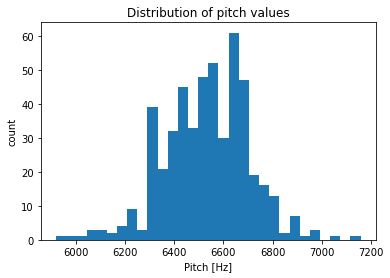

In [4]:
plt.hist(pitch_data, bins = 30)#math.floor(np.sqrt(M))
plt.title('Distribution of pitch values')
plt.xlabel('Pitch [Hz]')
plt.ylabel('count')

plt.show()

# Defining parameters of underlying probability distribution
Log-linear model for underlying interactions:
$$\log p(x|\theta) = \sum_i^N \theta_i x_i + \sum_{ij}^N \theta_{ij} x_i x_j + \sum_{ijk}^N \theta_{ijk} x_i x_j x_k +...= \sum_{\nu} \theta_{\nu} \prod_{i\in V_{\nu}} x_i -\log \mathcal{Z}$$

In [5]:

#dimension of data
T=len(samples[0])#21
#number of steps to do path integral for magnetization
n_e=20 
#number of shufflings for significance test
nmix=10
#number of pattern in full Ising model, after filtering by field
Nmax=1000
#number of samples for inference
#M=len(samples)


# Infering codewords from finite samples using uBIA
As a first step we list all the patterns that occur in the samples (if $T$ is large, we need to be careful with this step).

Secondly, we include in this list patterns which do not occur but could be a relevant pattern.

Next, we calculate "the fields" of each pattern, checking how such patterns over or under occur in relation to our expectation (no interaction). The field gives the individual evidence that a pattern should be considered as a codeword. Here we select the Nmax patterns with higher fields.

Because overlapping patterns or codewords try to explain the same correlations, we need a type of competition between them to determine which are the true patterns and which are by-products of the others. This competition is implemented through couplings $J_{\mu\nu}$.

A key parameter of uBIA is epsilon, the inverse regularization. Epsilon regulates how far we move away from our "no-interaction null model". Epsilon can not be too large as some of the approximation of the method are not longer valid, but if it is too small we do not allow the correlations in the samples to matter.

Finally, we present a list of words ordered by their marginal magnetizations, a quantity directly proportional to their probability of being a codeword. These results are presented as:

(word, marginal magnetization, individual field, frequency in samples, expected frecuency from null model)

The list ordered by marginal magnetization is presented at the largest epsilon allowed by our approximations, but you can checked how the list changes at other levels ($ne_{test} \in\{1,2,..,20\}$).

In [7]:
print(samples[:10])

[[1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0]
 [1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0]
 [1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0]]


In [10]:
hcutoff=0.05

M=len(samples) #number of samples
pi=np.sum(samples,axis=0)
pi=[1.*i/M for i in pi] #empirical individual probabilities

start_time = time.time()

dicset=uBIAmodule.extract_patt(samples)
print("Number of candidate words: ",len(dicset))

sorted_patt=uBIAmodule.magn_field(dicset,M,pi)
Nmax1=min(Nmax,len(sorted_patt))
print(len(sorted_patt))

h0=[sorted_patt[i][1][0] for i in range(Nmax1)]

Jvw=uBIAmodule.couplings(sorted_patt, M, pi, Nmax1)

results=uBIAmodule.marg_magn_h1ef(h0, Jvw, M)
mi=results[0]
h1ef=results[1]

neopt=uBIAmodule.level_inverse_reg(h0,h1ef,n_e,0.5)
print("Largest epsilon allowed by our approximations:",neopt,"*1/(20M)")

mm_sorted_patt=uBIAmodule.marg_magn_sorted(sorted_patt,mi,neopt)

#codewords that include the behavior
codewords=uBIAmodule.select_codewords(sorted_patt,mi,neopt) 

#codewords that include the behavior and overoccur
codewords_over=uBIAmodule.select_codewords_overoccur(sorted_patt,mi,neopt)

print("\n Sorted by marginal magnetization at e* (c=0.5):")
for pp in mm_sorted_patt[:5]:
    print(pp)

#print("\n Codewords that include the behavior, sorted by marginal magnetization at e* (c=0.5):")
#for pp in codewords[:min(5,len(codewords))]:
#    print(pp)  
    
print("\n Codewords that overoccur with behavior, sorted by marginal magnetization at e* (c=0.5):")
for pp in codewords_over[:min(10,len(codewords))]:
    print(pp)
    

print("\n--- %s seconds ---" % (time.time() - start_time))

Number of candidate words:  34156
1000
Largest epsilon allowed by our approximations: 20 *1/(20M)

 Sorted by marginal magnetization at e* (c=0.5):
((13, 14), [0.6258110242463125, 459.56160270345424, 41, 84.6867469879518])
((12, 13), [0.600168798202174, 431.3562006044207, 36, 78.32530120481927])
((17, 18), [0.5085644638766619, 374.3053376956804, 9, 48.25301204819277])
((11, 12), [0.5023002113067739, 333.8829462460412, 26, 63.29317269076305])
((14, 15), [0.49265989586408715, 350.30968073192753, 37, 75.27710843373494])

 Codewords that overoccur with behavior, sorted by marginal magnetization at e* (c=0.5):
((0, 9, 13), [0.16420223222434543, 95.083087594244, 36, 16.102409638554217])
((0, 10, 13), [0.14417581411874605, 71.0012307904867, 43, 25.445783132530117])
((0, 15, 18), [0.12298208884636364, 51.66139095502345, 39, 23.85542168674699])
((0, 11, 14), [0.10789005351309527, 46.66878298503931, 49, 34.21686746987952])
((0, 12, 18), [0.10736561026267775, 44.79205227700613, 41, 26.70180722891

In [80]:
#mc[x_,m1_:Exp[-2.67]]:=m1 x^(-0.23)Exp[-0.015 (Log[x]^2)];#see mlevel_nf.nb
#nf=Table[0.005 Sqrt[2]^(i-1),{i,27}];

#mc[n_false=0.3, m1= magnetization 1st]= 1.290 m1

# Significance level
(slowest part ~4 min)

Through reshuffling of the columns of our original matrix (that is, keeping marginal probabilities but deleting interactions), we can obtain how large the marginal magnetization gets when there are no interactions. Namely, these positive values of marginal magnetizations are due to finite sampling.

mc[x_,m1_]:=m1 x^(-0.23)Exp[-0.015 (Log[x]^2)]

mc[n_false, m1= magnetization 1st]= m1 f(nf) (see sacaling between magn and n_false in mlevel_nf.nb)

mc[0.3,1]=1.29

mc[0.1,1]=1.57

mc[0.03,1]=1.86

In [11]:
start_time = time.time()

mcx=np.zeros((10,n_e+1)) #ten largest values of marg. magnetizations for codewords in shuffled data (for each level of ee)
mclowx=np.zeros((10,n_e+1))

for nn in range(nmix):#nmix

    #shuffling columns of data (keeping the firing rate fixed)
    tsam=np.transpose(samples)
    tsam_shuf=[shuffle(ti) for ti in tsam]
    sam_shuf=np.transpose(tsam_shuf)

    dicset_s=uBIAmodule.extract_patt(sam_shuf)
    #print(len(dicset_s))

    sorted_patt_s=uBIAmodule.magn_field(dicset_s,M,pi)
    #print(len(sorted_patt_s))
    Nmax_s=min(Nmax,len(sorted_patt_s))
    
    h0_s=[sorted_patt_s[i][1][0] for i in range(Nmax_s)]

    Jvw_s=uBIAmodule.couplings(sorted_patt_s, M, pi, Nmax_s)

    results_s=uBIAmodule.marg_magn_h1ef(h0_s, Jvw_s, M)
    mi_s=results_s[0]
    h1ef_s=results_s[1]
    
    for kk in range(n_e+1):
        #how strong can the marginal magnetizetion be for every level of \epsilon?
        mcx[:,kk]+=sorted(mi_s[:,kk],reverse=True)[:10]
        mclowx[:,kk]+=sorted(mi_s[:,kk])[:10]
    
    print(nn,"--- %.2f seconds ---" % (time.time() - start_time))

mcx=(1./nmix)*mcx
mclowx=(1./nmix)*mclowx

print(mcx[0])
#print(mclowx[0])

0 --- 25.72 seconds ---
1 --- 50.00 seconds ---
2 --- 73.91 seconds ---
3 --- 98.49 seconds ---
4 --- 124.53 seconds ---
5 --- 149.26 seconds ---
6 --- 174.26 seconds ---
7 --- 200.38 seconds ---
8 --- 225.44 seconds ---
9 --- 251.61 seconds ---
[0.         0.00307424 0.00608647 0.00903657 0.01192441 0.0147499
 0.01751296 0.02021352 0.02285152 0.02542693 0.02793972 0.03038988
 0.03279878 0.03520808 0.03757391 0.03989071 0.0421585  0.04437727
 0.04654706 0.04866788 0.05073977]


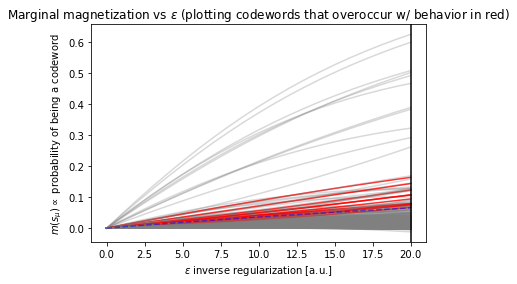

In [12]:
# If we want to obtain less than one false word, we need to put our threshold above the maximum marginal magnetizetion that we get by reshuffling. The parameter mc1 controls how far above.

if M<800:
    mc1=1.29 #for $M \in (200,800)$
elif (M>=800) and (M<1600):
    mc1=1.57 #for $M \in (800,1600)$
elif M>=1600:
    mc1=1.86 #for $M \in (1600,3200)$

for j in range(len(mi)):
    if (mi[j][neopt]>mc1*mcx[0][neopt]) and (0 in sorted_patt[j][0]) and (sorted_patt[j][1][1]>sorted_patt[j][1][2]):
        plt.plot(mi[j],'red',alpha=0.8)
    else:
        plt.plot(mi[j],'gray',alpha=0.3)


plt.plot(mc1*mcx[0],'b--',alpha=0.5)

plt.axvline(x=neopt, color='k')       

plt.title('Marginal magnetization vs $\epsilon$ (plotting codewords that overoccur w/ behavior in red)')
plt.ylabel('$m(s_{\mu}) \propto$ probability of being a codeword')
plt.xlabel('$\epsilon$ inverse regularization [a.u.]')

plt.show()

In [13]:
threshold=mc1*mcx[0][neopt]
print(threshold)
print("\n Codewords that overoccur w/ behavior, which are above threshold:")
for pp in codewords_over:#[:40]:
    if pp[1][0]>threshold:
        print(pp)

0.06545430644623867

 Codewords that overoccur w/ behavior, which are above threshold:
((0, 9, 13), [0.16420223222434543, 95.083087594244, 36, 16.102409638554217])
((0, 10, 13), [0.14417581411874605, 71.0012307904867, 43, 25.445783132530117])
((0, 15, 18), [0.12298208884636364, 51.66139095502345, 39, 23.85542168674699])
((0, 11, 14), [0.10789005351309527, 46.66878298503931, 49, 34.21686746987952])
((0, 12, 18), [0.10736561026267775, 44.79205227700613, 41, 26.701807228915662])
((0, 12, 14), [0.09450319768007628, 38.45619990394883, 56, 42.12951807228915])
((0, 9, 13, 17), [0.079534217704374, 42.432088514161656, 19, 5.755479750326607])
((0, 16, 19), [0.07931108555435255, 32.41134315167478, 34, 21.734939759036145])
((0, 15), [0.07837741733949007, 24.13755020080321, 101, 88.0])
((0, 18), [0.07670428589095074, 24.474774096385545, 80, 67.5])
((0, 9, 12), [0.07270795824212455, 44.9761026751439, 30, 16.021084337349397])
((0, 13, 15), [0.06711629870575644, 22.183849930131316, 46, 34.987951807228

Highlighted codeword:  [8, 12, 16]


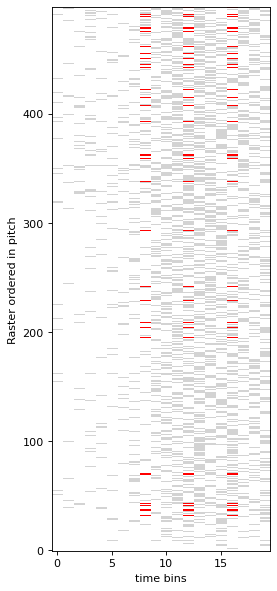

In [15]:
#Highlighting codewords in ordered (by pitch value) scatter plot

word=codewords_over[6][0][1:]#removing 1st component (binary behavior), and substracting 1
word=[tt-1 for tt in word]
print("Highlighted codeword: ",word)

ind_pitch_high=sorted(range(len(pitch_data)),key=pitch_data.__getitem__)#, reverse=True

ordered_spikes_data=[spikes_data[j] for j in ind_pitch_high]
ordered_spikes_data2=[spikes for spikes in ordered_spikes_data]

for j in ind_pitch_high:
    if [ordered_spikes_data[j][i] for i in word]==[1]*len(word):
        for tt in word:
            ordered_spikes_data2[j][tt]+=1

# make a color map of fixed colors
cmap = colors.ListedColormap(['white', 'lightgray', 'red'])
bounds=[-0.5,0.5,1.5,2.5]
norm = colors.BoundaryNorm(bounds, cmap.N)
plt.figure(figsize=(12, 9), dpi=80)

# tell imshow about color map so that only set colors are used
plt.imshow(ordered_spikes_data2, interpolation='nearest', origin='lower', cmap=cmap, norm=norm, aspect=0.1)
plt.xlabel('time bins')
plt.ylabel('Raster ordered in pitch')

plt.show()

### Exercise
Redo the analysis binarizing pitch as 1 when it is below median, and obtain codewords that include the behavior (low pitch) and over occur.

It is not neccessary to perform again the reshuffling, as the threshold (which depends only in individual frequencies) will not change.